# WeatherPy
----

In [61]:
# Dependencies and Setup
import os
import requests
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
from citipy import citipy
import scipy.stats as st
from scipy.stats import linregress
from scipy import stats

# Import API key
from api_keys import weather_api_key

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180) 

## Generate Cities List

In [62]:
# Generate Cities List
cities = []

# Create a set of random Lat and lng combinations
lats = np.random.uniform(low=lat_range[0], high=lat_range[1], size=1500)
lngs = np.random.uniform(low=lng_range[0], high=lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each Lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to the cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(len(cities))

633


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [63]:
# Perform API Calls
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "metric"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="

In [65]:
# Lists to hold data
location = []
lat = []
long = []
temp = []
maxtemp = []
mintemp = []
humidity = []
clouds = []
wind = []
country = []
datetime = []

# check if resources folder exist or not,if not it will create one
if not os.path.exists("resources"):
    os.mkdir("resources")

# Iterate through the cities list
for city in cities:
    response = requests.get(query_url + city).json()
    try: 
        lat.append(response['coord']['lat'])
        long.append(response['coord']['lon'])
        location.append(city)
        temp.append(response['main']['temp'])
        maxtemp.append(response['main']['temp_max'])
        mintemp.append(response['main']['temp_min'])
        humidity.append(response['main']['humidity'])
        clouds.append(response['clouds']['all'])
        wind.append(response['wind']['speed'])
        country.append(response['sys']['country'])
        datetime.append(response['dt'])
        with open("resources/Cities_List.txt", "a") as file:
            file.write(f'Location number: {len(country)} the city of: {city} has been added to the list of possible travel destinations\n')
    except KeyError:
        with open("resources/Cities_List.txt", "a") as file:
            file.write(f"The city of: {city} is unavailable\n")

In [66]:
# Create dataframe with data
weather_data = pd.DataFrame({
    "City": location,
    "Latitude": lat,
    "Longitude": long,
    "Temperature (C)": temp,
    "Humidity (%)": humidity,
    "Cloudiness (%)": clouds,
    "Wind Speed (mph)": wind
})

# Save dataframe as CSV
weather_data.to_csv('resources/Weather_Data.csv', index=False)

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [67]:
# Storing the list of values we stored into a main dataframe (weather_data)

weather_dict = {
    "City": location,
    "Lat": lat,
    "Long": long,
    "Temp": temp,
    "Max Temp": maxtemp,
    "Min Temp": mintemp,
    "Humidity" : humidity,
    "Clouds": clouds,
    "Wind" : wind,
    "Country" : country,
    "Datetime" : datetime
}
weather_data = pd.DataFrame(weather_dict)

# Output the dataframe complied into a CSV that will be used for the VacationPy 
weather_data.to_csv('resources/City_Data.csv', index=False)

In [68]:
# inspecting the weather_data dataframe
weather_data.head()

,City,Lat,Long,Temp,Max Temp,Min Temp,Humidity,Clouds,Wind,Country,Datetime
0,rikitea,-23.1203,-134.9692,25.73,25.73,25.73,74,62,4.39,PF,1674921814
1,sao joao da barra,-21.6403,-41.0511,32.05,32.05,32.05,77,66,4.50,BR,1674922014
2,mar del plata,-38.0023,-57.5575,21.04,26.02,21.04,91,76,2.68,AR,1674922015
3,pangnirtung,66.1451,-65.7125,-35.00,-35.00,-35.00,68,20,1.03,CA,1674922015
4,iwaki,37.0500,140.8833,0.01,0.01,-0.68,58,40,2.68,JP,1674921962


In [69]:
# inspecting the weather_data dataframe
weather_data.describe()

,Lat,Long,Temp,Max Temp,Min Temp,Humidity,Clouds,Wind,Datetime
count,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,5.870000e+02
mean,21.197177,17.792670,9.605928,9.844838,9.338348,72.345826,60.052811,3.714106,1.674922e+09
std,33.114518,87.841603,18.521298,18.503055,18.544542,22.278749,39.451040,2.722061,1.434986e+02
min,-54.800000,-175.200000,-47.550000,-47.550000,-47.550000,7.000000,0.000000,0.000000,1.674922e+09
25%,-6.199150,-57.180150,-2.320000,-2.105000,-3.245000,61.000000,20.000000,1.690000,1.674922e+09
50%,27.181000,20.134700,14.730000,14.730000,14.590000,77.000000,75.000000,3.090000,1.674922e+09
75%,49.308200,91.070950,25.100000,25.180000,24.995000,89.000000,100.000000,5.140000,1.674922e+09
max,78.218600,179.316700,39.260000,39.260000,39.260000,100.000000,100.000000,16.460000,1.674922e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [70]:
# find all cities with humidity over 100%
high_humidity_cities = weather_data[weather_data['Humidity'] > 100]

# print the names of the cities with high humidity
if high_humidity_cities.empty:
    print("there are no cities that have humidity > 100%")
else:
    print(high_humidity_cities['City'])


there are no cities that have humidity > 100%


## Plotting the Data
* Use proper labelling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [71]:
# Set graph size for all graphs
plt.rcParams["figure.figsize"] = (4,4)

from datetime import datetime

## Latitude vs. Temperature Plot

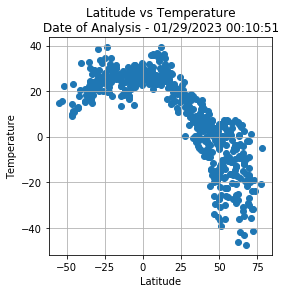

In [72]:
plt.scatter(weather_data["Lat"], weather_data["Temp"], marker="o")
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")
plt.title(f"Latitude vs Temperature\nDate of Analysis - {date_time}")
plt.xlabel("Latitude")
plt.ylabel("Temperature")
plt.grid()
plt.savefig("plot_images/Latitude vs Temperature.png")
plt.show()

## Latitude vs. Humidity Plot

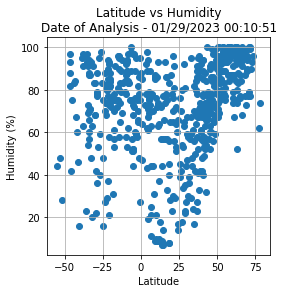

In [73]:
plt.scatter(weather_data["Lat"], weather_data["Humidity"], marker="o")
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")
plt.title(f"Latitude vs Humidity\nDate of Analysis - {date_time}")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid()
plt.savefig("plot_images/Humidity_vs_Latitude.png")
plt.show()

## Latitude vs. Cloudiness Plot

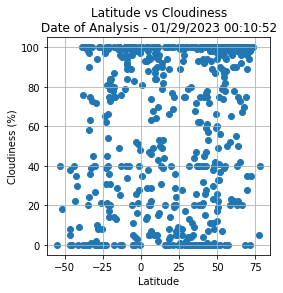

In [74]:
plt.scatter(weather_data["Lat"], weather_data["Clouds"], marker="o")
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")
plt.title(f"Latitude vs Cloudiness\nDate of Analysis - {date_time}")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid()
plt.savefig("plot_images/Cloudiness_vs_Latitude.png")
plt.show()

## Latitude vs. Wind Speed Plot

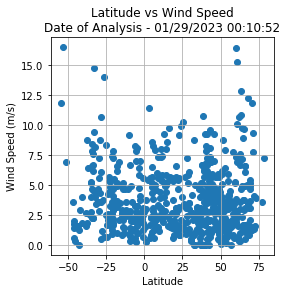

In [75]:
plt.scatter(weather_data["Lat"], weather_data["Wind"], marker="o")
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")
plt.title(f"Latitude vs Wind Speed\nDate of Analysis - {date_time}")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (m/s)")
plt.grid()
plt.savefig("plot_images/Wind_Speed_vs_Latitude.png")
plt.show()

## Linear Regression

In [76]:
# Variables extract only the required hemisphere data from the weather_data dataframe
northern_hemisphere = weather_data[weather_data["Lat"] >= 0]
southern_hemisphere = weather_data[weather_data["Lat"] < 0]

###  Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

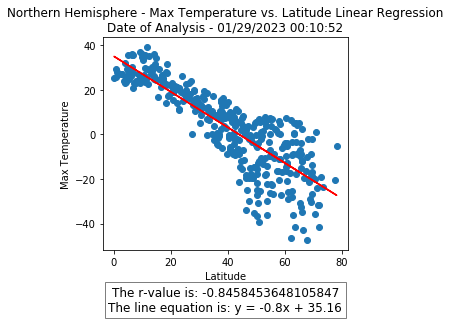

In [77]:
from datetime import datetime

# Perform linear regression of "Max Temp vs. Latitude" for the northern hemisphere
x_values = northern_hemisphere["Lat"]
y_values = northern_hemisphere["Max Temp"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Plot the linear regression on a scatter plot
fig, ax = plt.subplots(figsize=(5.5, 4.8))
ax.scatter(x_values, y_values)
ax.plot(x_values, regress_values, "r-")

# Add labels and title to the plot
plt.xlabel("Latitude")
plt.ylabel("Max Temperature")

# Get the current date and time
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")

plt.title(f"Northern Hemisphere - Max Temperature vs. Latitude Linear Regression\nDate of Analysis - {date_time}")

# Increase the distance between the title and the plot
plt.subplots_adjust(top=0.9)

# Add the r-value and the line equation centered at the bottom of the plot
plt.text(0.5, -0.3,
f"The r-value is: {rvalue}\nThe line equation is: y = {round(slope, 2)}x + {round(intercept, 2)}",
fontsize=12, ha="center", va="bottom", bbox=dict(facecolor="white", alpha=0.5),
transform=ax.transAxes)

# Save the plot
plt.tight_layout()
plt.savefig("plot_images/Northern Hemisphere - Max Temp vs Latitude Linear Regression.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

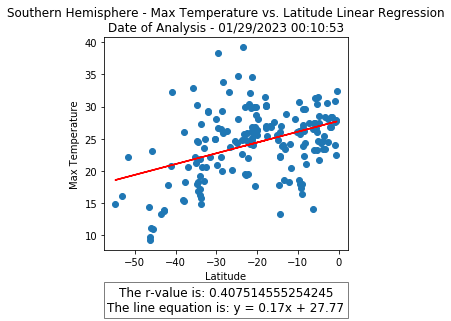

In [78]:
# Perform linear regression of "Max Temp vs. Latitude" for the southern hemisphere
x_values = southern_hemisphere["Lat"]
y_values = southern_hemisphere["Max Temp"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Plot the linear regression on a scatter plot
fig, ax = plt.subplots(figsize=(5.5, 4.8))
ax.scatter(x_values, y_values)
ax.plot(x_values, regress_values, "r-")

# Add labels and title to the plot
plt.xlabel("Latitude")
plt.ylabel("Max Temperature")

# Get the current date and time
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")

plt.title(f"Southern Hemisphere - Max Temperature vs. Latitude Linear Regression\nDate of Analysis - {date_time}")

# increase the distance between the title and the plot
plt.subplots_adjust(top=0.9)

# Add the r-value and the line equation centered at the bottom of the plot
plt.text(0.5, -0.3,
f"The r-value is: {rvalue}\nThe line equation is: y = {round(slope, 2)}x + {round(intercept, 2)}",
fontsize=12, ha="center", va="bottom", bbox=dict(facecolor="white", alpha=0.5),
transform=ax.transAxes)

# Save the plot
plt.tight_layout()
plt.savefig("plot_images/Southern Hemisphere - Max Temp vs Latitude Linear Regression.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

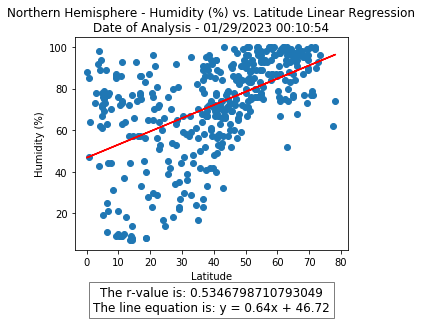

In [79]:
# Perform linear regression of "Humidity (%) vs. Latitude" for the northern hemisphere
x_values = northern_hemisphere["Lat"]
y_values = northern_hemisphere["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Plot the linear regression on a scatter plot
fig, ax = plt.subplots(figsize=(5.5, 4.8))
ax.scatter(x_values, y_values)
ax.plot(x_values, regress_values, "r-")

# Add labels and title to the plot
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

# Get the current date and time
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")

plt.title(f"Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression\nDate of Analysis - {date_time}")

# increase the distance between the title and the plot
plt.subplots_adjust(top=0.9)

# Add the r-value and the line equation centered at the bottom of the plot
plt.text(0.5, -0.3,
f"The r-value is: {rvalue}\nThe line equation is: y = {round(slope, 2)}x + {round(intercept, 2)}",
fontsize=12, ha="center", va="bottom", bbox=dict(facecolor="white", alpha=0.5),
transform=ax.transAxes)

# Save the plot
plt.tight_layout()
plt.savefig("plot_images/Northern Hemisphere - Humidity (%) vs Latitude Linear Regression.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

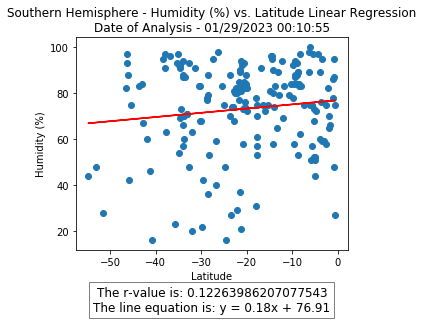

In [80]:
# Perform linear regression of "Humidity (%) vs. Latitude" for the southern hemisphere
x_values = southern_hemisphere["Lat"]
y_values = southern_hemisphere["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Plot the linear regression on a scatter plot
fig, ax = plt.subplots(figsize=(5.5, 4.8))
ax.scatter(x_values, y_values)
ax.plot(x_values, regress_values, "r-")

# Add labels and title to the plot
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

# Get the current date and time
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")

plt.title(f"Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression\nDate of Analysis - {date_time}")

# increase the distance between the title and the plot
plt.subplots_adjust(top=0.9)

# Add the r-value and the line equation centered at the bottom of the plot
plt.text(0.5, -0.3,
f"The r-value is: {rvalue}\nThe line equation is: y = {round(slope, 2)}x + {round(intercept, 2)}",
fontsize=12, ha="center", va="bottom", bbox=dict(facecolor="white", alpha=0.5),
transform=ax.transAxes)

# Save the plot
plt.tight_layout()
plt.savefig("plot_images/Southern Hemisphere - Humidity (%) vs Latitude Linear Regression.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

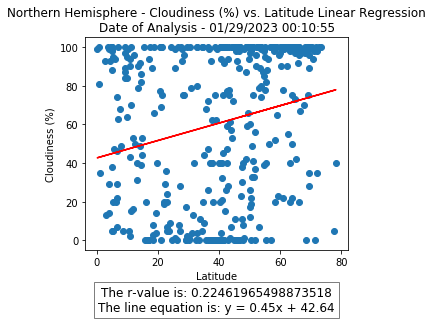

In [81]:
# Perform linear regression of "Cloudiness (%) vs. Latitude" for the northern hemisphere
x_values = northern_hemisphere["Lat"]
y_values = northern_hemisphere["Clouds"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Plot the linear regression on a scatter plot
fig, ax = plt.subplots(figsize=(5.5, 4.8))
ax.scatter(x_values, y_values)
ax.plot(x_values, regress_values, "r-")

# Add labels and title to the plot
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

# Get the current date and time
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")

plt.title(f"Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression\nDate of Analysis - {date_time}")

# increase the distance between the title and the plot
plt.subplots_adjust(top=0.9)

# Add the r-value and the line equation centered at the bottom of the plot
plt.text(0.5, -0.3,
f"The r-value is: {rvalue}\nThe line equation is: y = {round(slope, 2)}x + {round(intercept, 2)}",
fontsize=12, ha="center", va="bottom", bbox=dict(facecolor="white", alpha=0.5),
transform=ax.transAxes)

# Save the plot
plt.tight_layout()
plt.savefig("plot_images/Northern Hemisphere - Cloudiness (%) vs Latitude Linear Regression.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

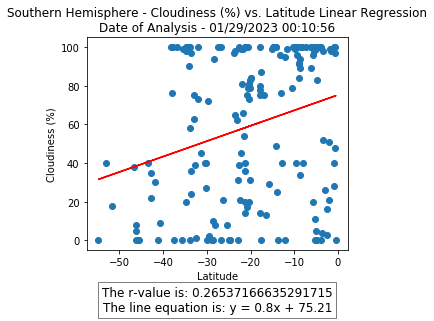

In [82]:
# Perform linear regression of "Cloudiness (%) vs. Latitude" for the southern hemisphere
x_values = southern_hemisphere["Lat"]
y_values = southern_hemisphere["Clouds"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Plot the linear regression on a scatter plot
fig, ax = plt.subplots(figsize=(5.5, 4.8))
ax.scatter(x_values, y_values)
ax.plot(x_values, regress_values, "r-")

# Add labels and title to the plot
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

# Get the current date and time
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")

plt.title(f"Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression\nDate of Analysis - {date_time}")

# increase the distance between the title and the plot
plt.subplots_adjust(top=0.9)

# Add the r-value and the line equation centered at the bottom of the plot
plt.text(0.5, -0.3,
f"The r-value is: {rvalue}\nThe line equation is: y = {round(slope, 2)}x + {round(intercept, 2)}",
fontsize=12, ha="center", va="bottom", bbox=dict(facecolor="white", alpha=0.5),
transform=ax.transAxes)

# Save the plot
plt.tight_layout()
plt.savefig("plot_images/Southern Hemisphere - Cloudiness (%) vs Latitude Linear Regression.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Wind Speed (m/s) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

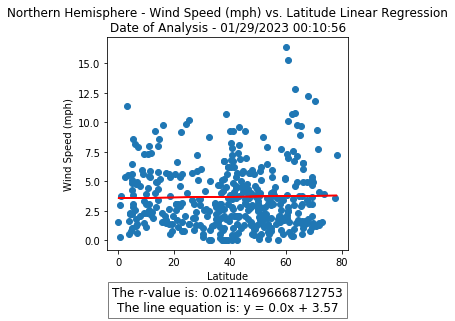

In [83]:
# Perform linear regression of "Wind Speed (mph) vs. Latitude" for the northern hemisphere
x_values = northern_hemisphere["Lat"]
y_values = northern_hemisphere["Wind"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Plot the linear regression on a scatter plot
fig, ax = plt.subplots(figsize=(5.5, 4.8))
ax.scatter(x_values, y_values)
ax.plot(x_values, regress_values, "r-")

# Add labels and title to the plot
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

# Get the current date and time
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")

plt.title(f"Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression\nDate of Analysis - {date_time}")

# increase the distance between the title and the plot
plt.subplots_adjust(top=0.9)

# Add the r-value and the line equation centered at the bottom of the plot
plt.text(0.5, -0.3,
f"The r-value is: {rvalue}\nThe line equation is: y = {round(slope, 2)}x + {round(intercept, 2)}",
fontsize=12, ha="center", va="bottom", bbox=dict(facecolor="white", alpha=0.5),
transform=ax.transAxes)

# Save the plot
plt.tight_layout()
plt.savefig("plot_images/Northern Hemisphere - Wind Speed vs Latitude Linear Regression.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

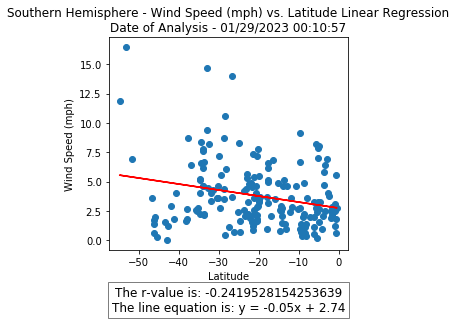

In [84]:
# Perform linear regression of "Wind Speed (mph) vs. Latitude" for the southern hemisphere
x_values = southern_hemisphere["Lat"]
y_values = southern_hemisphere["Wind"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Plot the linear regression on a scatter plot
fig, ax = plt.subplots(figsize=(5.5, 4.8))
ax.scatter(x_values, y_values)
ax.plot(x_values, regress_values, "r-")

# Add labels and title to the plot
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

# Get the current date and time
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")

plt.title(f"Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression\nDate of Analysis - {date_time}")

# increase the distance between the title and the plot
plt.subplots_adjust(top=0.9)

# Add the r-value and the line equation centered at the bottom of the plot
plt.text(0.5, -0.3, 
         f"The r-value is: {rvalue}\nThe line equation is: y = {round(slope, 2)}x + {round(intercept, 2)}",
         fontsize=12, ha="center", va="bottom", bbox=dict(facecolor="white", alpha=0.5),
         transform=ax.transAxes)

# Save the plot
plt.tight_layout()
plt.savefig("plot_images/Southern Hemisphere - Wind Speed vs Latitude.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
